# Makemore 3 (bis): vers une torchification, statistiques d'activation

## Reprise

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Words(object):

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi['.'] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [4]:
words = Words('civil_mots.txt')
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>
["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
ctoi = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
itoc = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0:

In [5]:
def build_dataset(words:list, ctoi: dict, context_size:int):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        ctoi: mapping of character to int
        context_size: how many characters we take to predict the next one

    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

context_size = 3
Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

torch.Size([54139, 3]) torch.Size([54139])
torch.Size([6735, 3]) torch.Size([6735])
torch.Size([6778, 3]) torch.Size([6778])


## Linear, BatchNorm1d: vers des réseaux plus profonds

API presque identique aux classes similaires dans [torch.nn](https://pytorch.org/docs/stable/nn.html).

In [7]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [8]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

## Hyperparamètres

In [10]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = words.nb_chars

## Réseau

In [11]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #layer.weight *= 1.0
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


## Entraînement

In [12]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [13]:
# same optimization as last time
max_steps = 1
batch_size = 32
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.7287


## Passe avant

Visualisation par histograme des activations lors de la passe avant, pour les couches `Tanh`.
On calcule la moyenne, l'écart-type et la saturation (`t.abs() > 0.97`) des valeurs.

### Initialisation des couches linéaires avec le 5/3 magique

In [14]:
def plot_forward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.38%
layer 3 (      Tanh): mean -0.03, std 0.70, saturated: 11.28%
layer 5 (      Tanh): mean -0.01, std 0.66, saturated: 6.12%
layer 7 (      Tanh): mean -0.00, std 0.65, saturated: 5.28%
layer 9 (      Tanh): mean +0.03, std 0.64, saturated: 5.03%


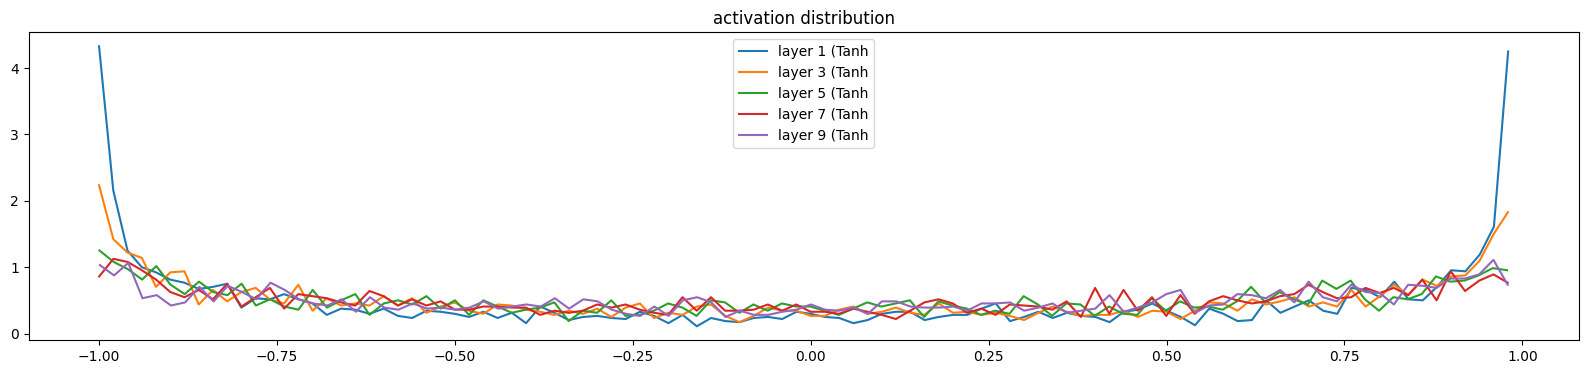

In [15]:
plot_forward_tanh(layers)

### Initialisation des couches linéaires sans facteur

48051
      0/      1: 3.7199
layer 1 (      Tanh): mean -0.02, std 0.63, saturated: 3.94%
layer 3 (      Tanh): mean -0.02, std 0.49, saturated: 0.22%
layer 5 (      Tanh): mean -0.00, std 0.40, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.31, saturated: 0.00%


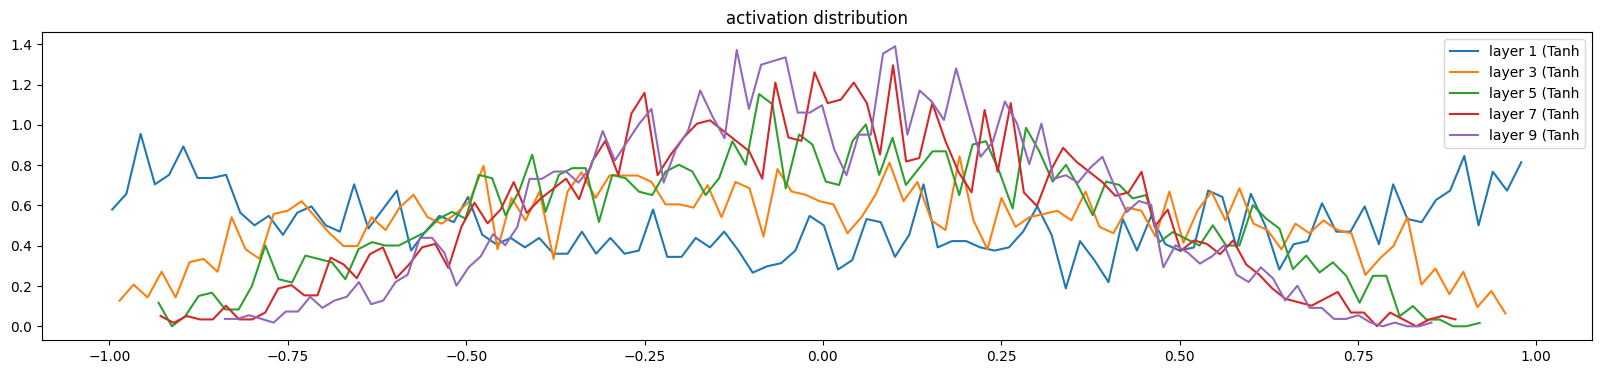

In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # !!!
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_forward_tanh(layers)

### Initialisation avec un facteur trop grand

48051
      0/      1: 3.7226
layer 1 (      Tanh): mean -0.03, std 0.86, saturated: 47.69%
layer 3 (      Tanh): mean -0.04, std 0.84, saturated: 42.16%
layer 5 (      Tanh): mean -0.02, std 0.83, saturated: 38.25%
layer 7 (      Tanh): mean +0.01, std 0.83, saturated: 38.00%
layer 9 (      Tanh): mean +0.01, std 0.83, saturated: 39.56%


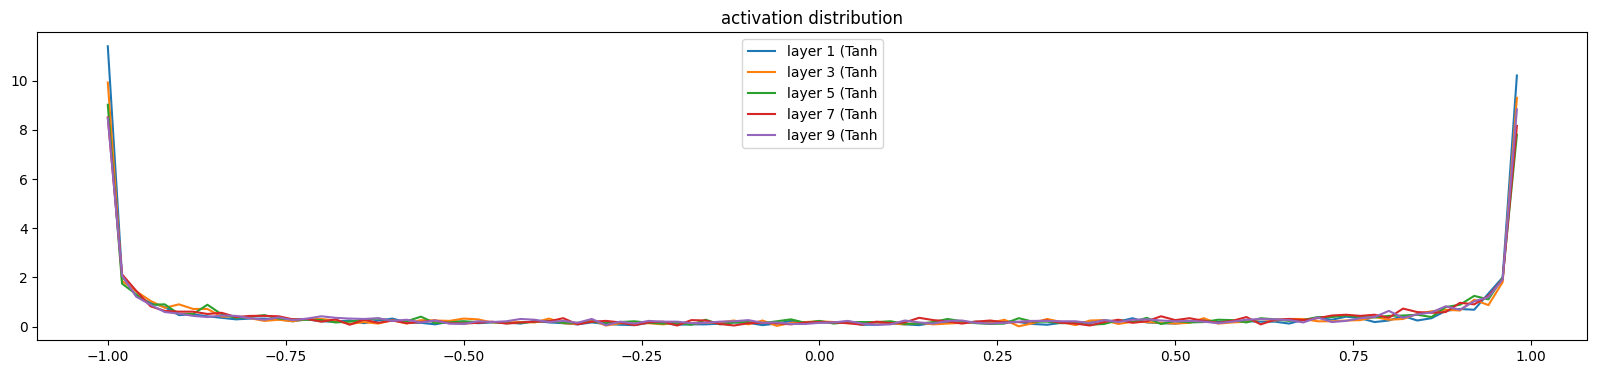

In [17]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3.0  # !!!
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_forward_tanh(layers)

$5\over 3$ semble donc être un bon facteur empirique.

## Passe arrière

In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [19]:
def plot_backward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
      if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')

      0/      1: 3.7287
layer 1 (      Tanh): mean -0.000017, std 4.173494e-04
layer 3 (      Tanh): mean -0.000003, std 4.117002e-04
layer 5 (      Tanh): mean +0.000003, std 3.824475e-04
layer 7 (      Tanh): mean -0.000007, std 3.465226e-04
layer 9 (      Tanh): mean -0.000001, std 3.125654e-04


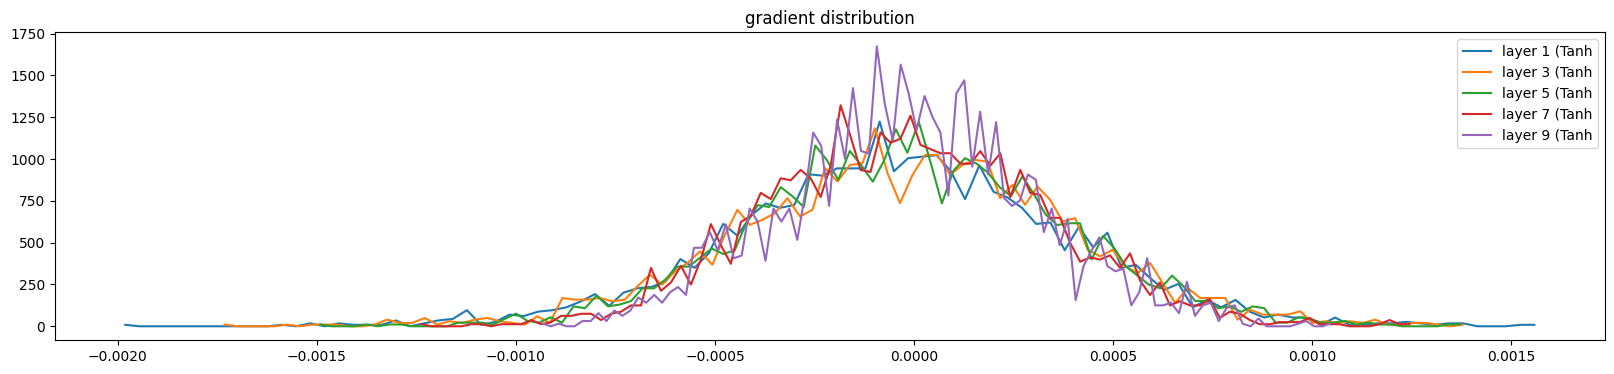

In [20]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


      0/      1: 3.7139
layer 1 (      Tanh): mean -0.000000, std 1.814538e-05
layer 3 (      Tanh): mean +0.000001, std 3.887038e-05
layer 5 (      Tanh): mean -0.000002, std 7.711226e-05
layer 7 (      Tanh): mean -0.000006, std 1.529500e-04
layer 9 (      Tanh): mean -0.000001, std 3.124173e-04


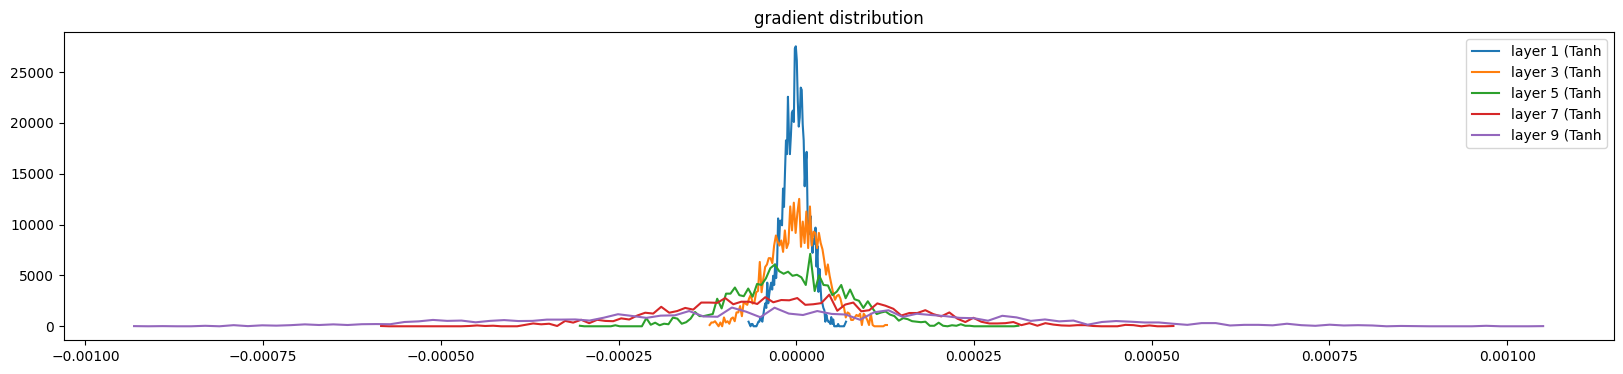

In [22]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


      0/      1: 3.2801
layer 1 (      Tanh): mean -0.000001, std 9.977492e-04
layer 3 (      Tanh): mean +0.000010, std 7.421207e-04
layer 5 (      Tanh): mean +0.000003, std 5.569780e-04
layer 7 (      Tanh): mean +0.000017, std 3.952166e-04
layer 9 (      Tanh): mean -0.000014, std 3.051525e-04


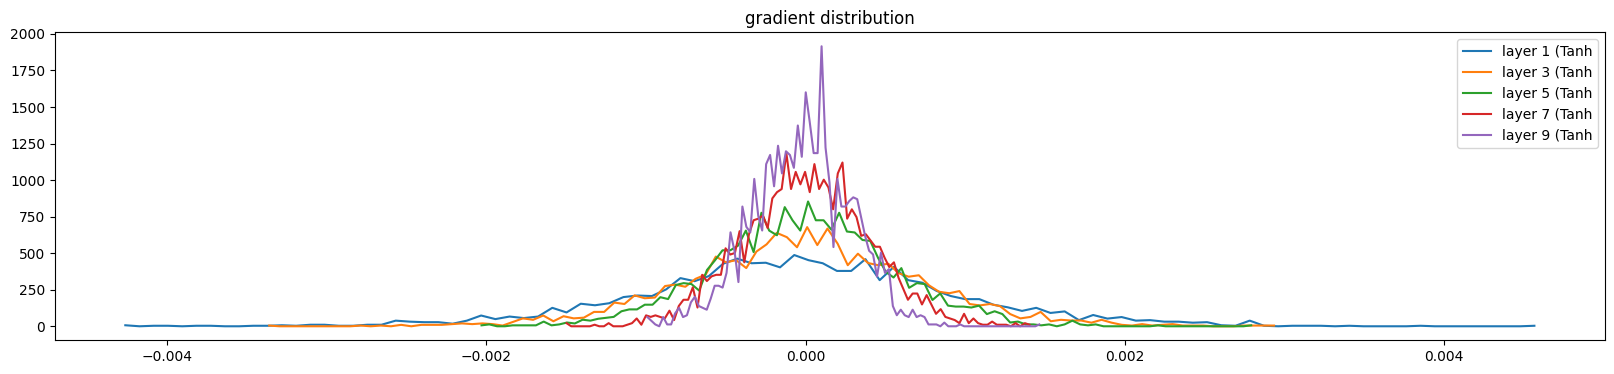

In [23]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

## Sans tanh

In [24]:
g = torch.Generator().manual_seed(2147483648) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [25]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 4.6409


In [26]:
def plot_forward_linear(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Linear):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')

def plot_backward_linear(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
      if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')

layer 0 (    Linear): mean -0.00, std 1.56, saturated: 52.06%
layer 1 (    Linear): mean -0.00, std 2.60, saturated: 68.88%
layer 2 (    Linear): mean -0.17, std 4.28, saturated: 81.25%
layer 3 (    Linear): mean -0.16, std 7.27, saturated: 89.72%
layer 4 (    Linear): mean +0.52, std 11.72, saturated: 92.09%


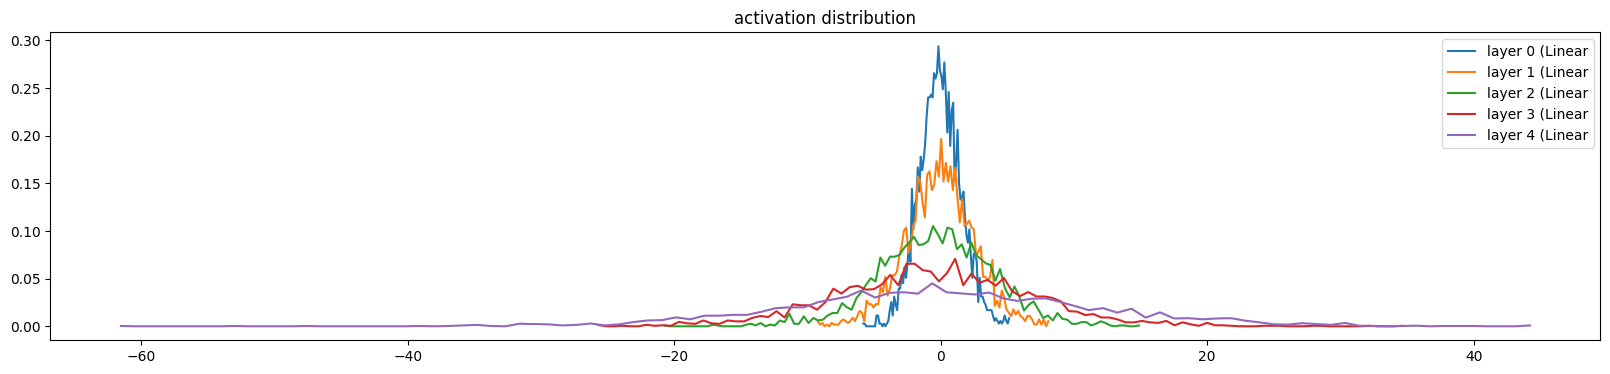

In [27]:
plot_forward_linear(layers)

layer 0 (    Linear): mean +0.000086, std 2.635194e-03
layer 1 (    Linear): mean -0.000001, std 1.586753e-03
layer 2 (    Linear): mean -0.000019, std 9.327194e-04
layer 3 (    Linear): mean +0.000003, std 5.413101e-04
layer 4 (    Linear): mean +0.000004, std 3.182479e-04


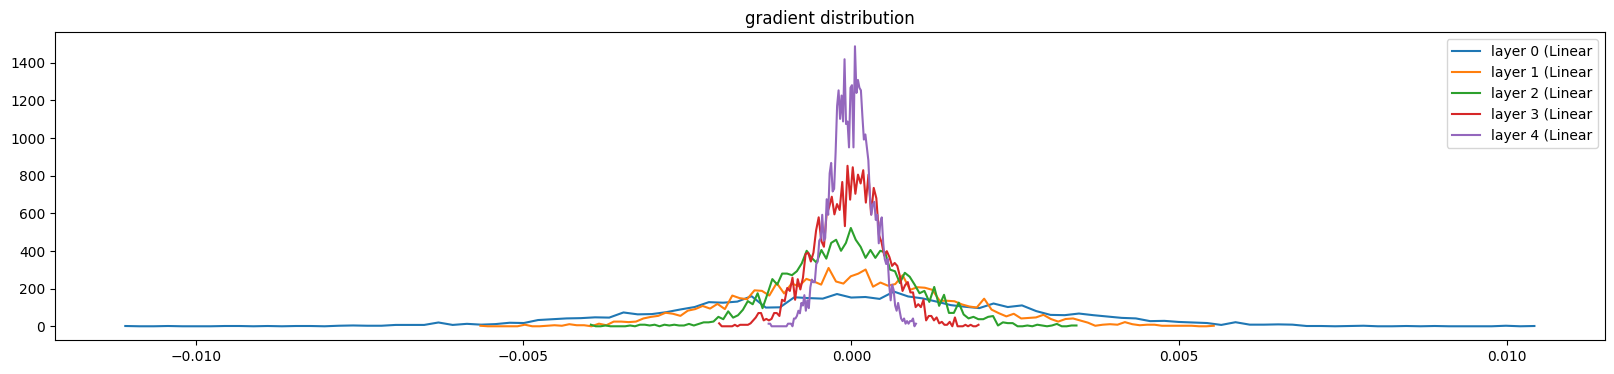

In [28]:
plot_backward_linear(layers)

On peut donc voir que sans la normalisation de type "Batch Normalisation", régler les interactions entre les différentes couches est un exercice difficile (A. Karpathy: ["_balancing a pencil on a finger_"](https://www.google.com/search?q=balancing+a+pencil+on+a+finger&dpr=2). 

In [29]:
## Interlude

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [31]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.7287


layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.38%
layer 3 (      Tanh): mean -0.03, std 0.70, saturated: 11.28%
layer 5 (      Tanh): mean -0.01, std 0.66, saturated: 6.12%
layer 7 (      Tanh): mean -0.00, std 0.65, saturated: 5.28%
layer 9 (      Tanh): mean +0.03, std 0.64, saturated: 5.03%
layer 1 (      Tanh): mean -0.000017, std 4.173494e-04
layer 3 (      Tanh): mean -0.000003, std 4.117002e-04
layer 5 (      Tanh): mean +0.000003, std 3.824475e-04
layer 7 (      Tanh): mean -0.000007, std 3.465226e-04
layer 9 (      Tanh): mean -0.000001, std 3.125654e-04


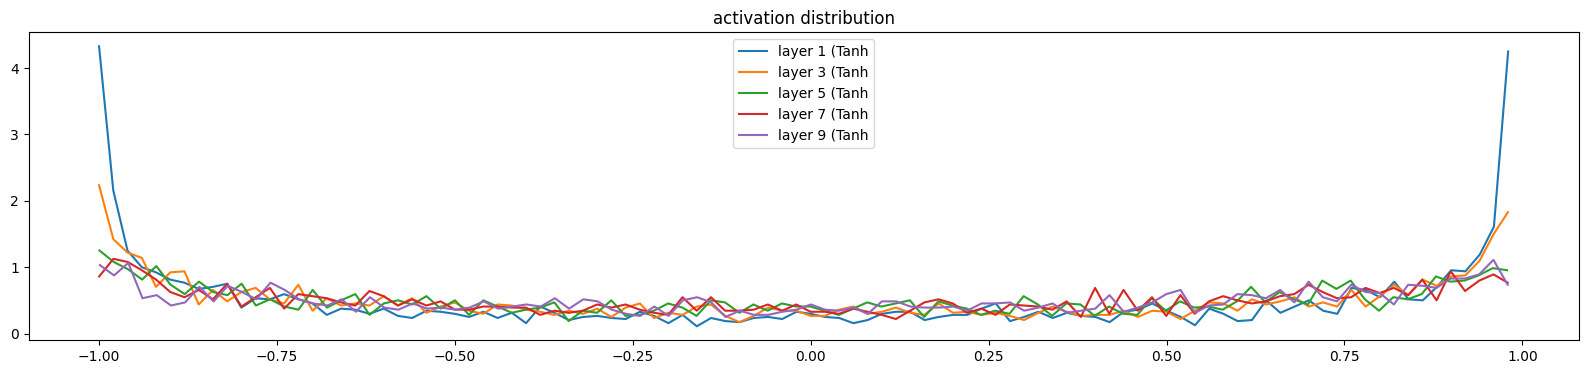

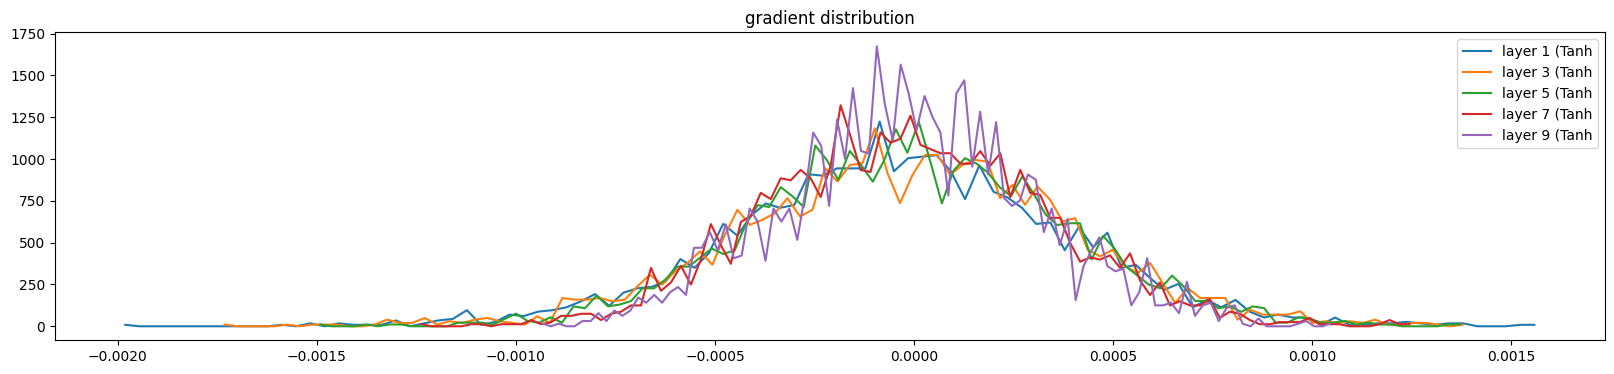

In [32]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)

### grad/data ratio

In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [34]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.7287


In [35]:
def plot_weight_parameters_gradients(parameters):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');

weight   (41, 10) | mean +0.000092 | std 1.049824e-03 | grad:data ratio 1.070850e-03
weight  (30, 100) | mean -0.000013 | std 1.247088e-03 | grad:data ratio 4.073353e-03
weight (100, 100) | mean +0.000020 | std 1.049583e-03 | grad:data ratio 6.258510e-03
weight (100, 100) | mean +0.000005 | std 9.535820e-04 | grad:data ratio 5.725559e-03
weight (100, 100) | mean +0.000012 | std 8.625889e-04 | grad:data ratio 5.179465e-03
weight (100, 100) | mean +0.000000 | std 7.713232e-04 | grad:data ratio 4.622407e-03
weight  (100, 41) | mean +0.000000 | std 1.811211e-02 | grad:data ratio 1.769739e+00


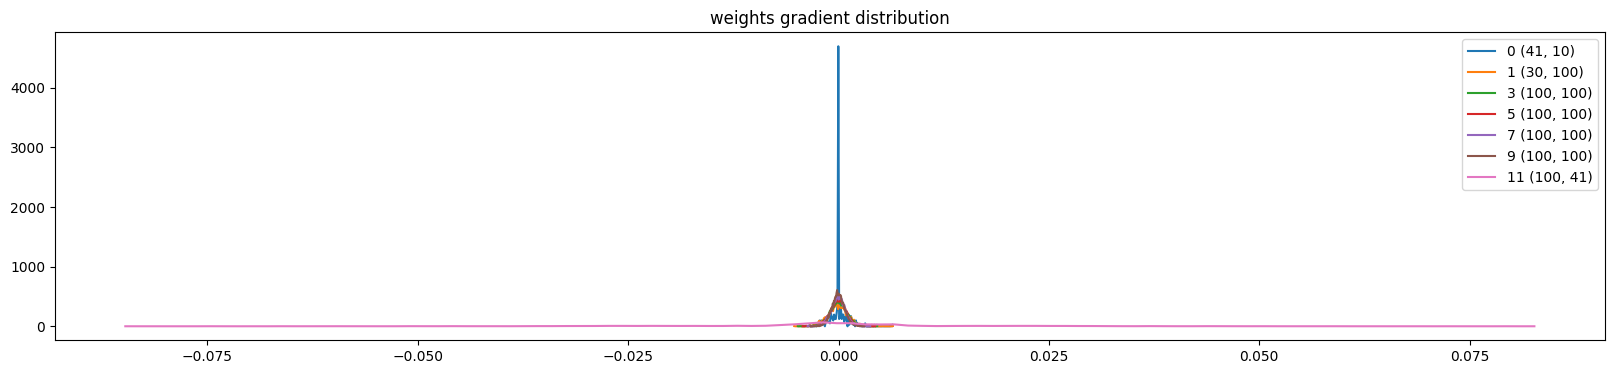

In [36]:
plot_weight_parameters_gradients(parameters)

In [37]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [38]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.7287


weight   (41, 10) | mean +0.000216 | std 1.100465e-02 | grad:data ratio 1.117225e-02
weight  (30, 100) | mean -0.000005 | std 1.267577e-02 | grad:data ratio 4.086826e-02
weight (100, 100) | mean +0.000008 | std 1.030922e-02 | grad:data ratio 5.995005e-02
weight (100, 100) | mean +0.000140 | std 9.582085e-03 | grad:data ratio 5.628245e-02
weight (100, 100) | mean +0.000057 | std 8.198062e-03 | grad:data ratio 4.822179e-02
weight (100, 100) | mean -0.000073 | std 6.510483e-03 | grad:data ratio 3.822853e-02
weight  (100, 41) | mean -0.000000 | std 1.711820e-02 | grad:data ratio 2.036719e-01


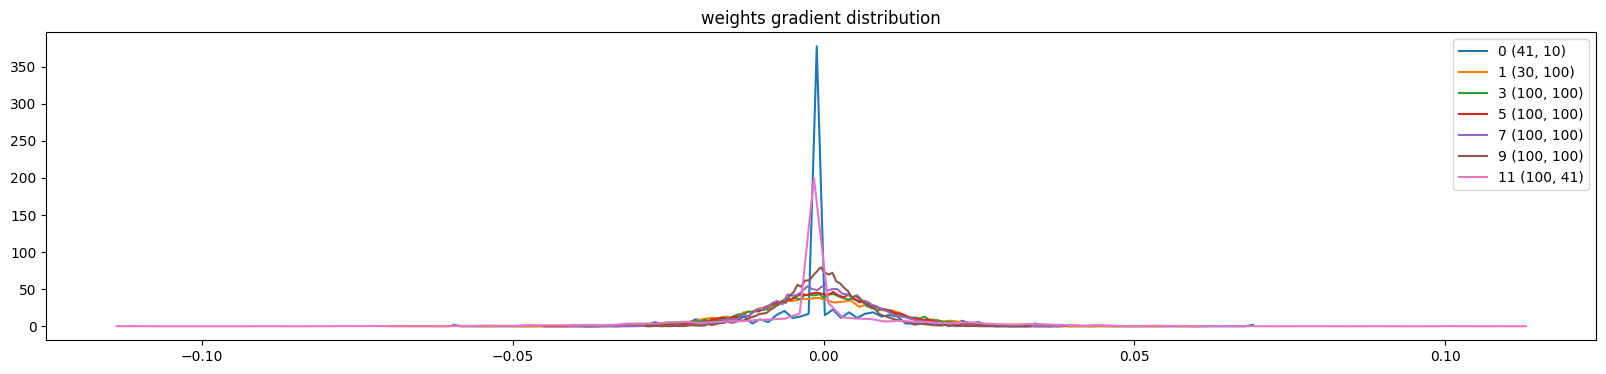

In [39]:
plot_weight_parameters_gradients(parameters)

## update data ratio

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [41]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.7287


In [42]:
def plot_update_weights_ratio(parameters):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

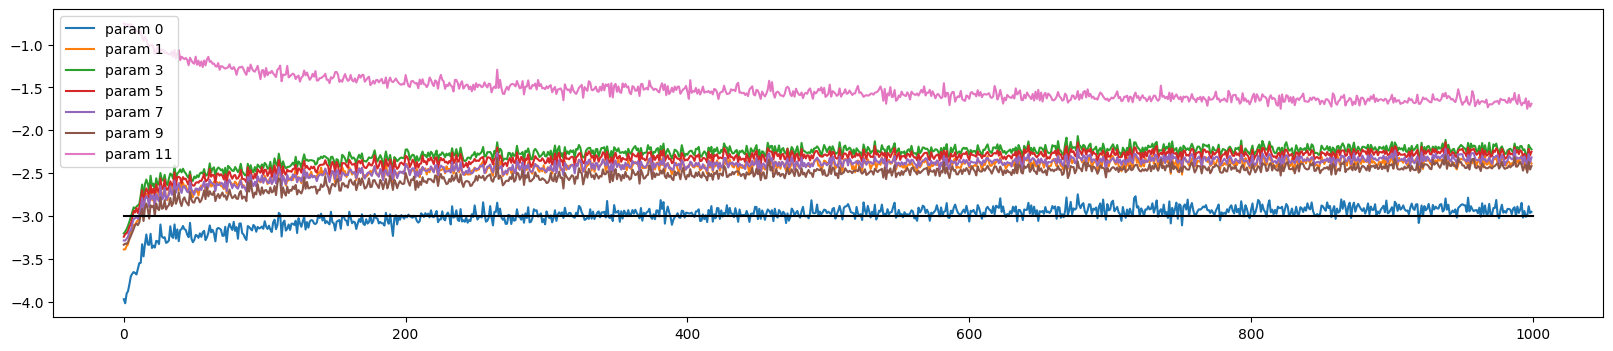

In [43]:
plot_update_weights_ratio(parameters)

In [44]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.001 # if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [45]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [46]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.7287


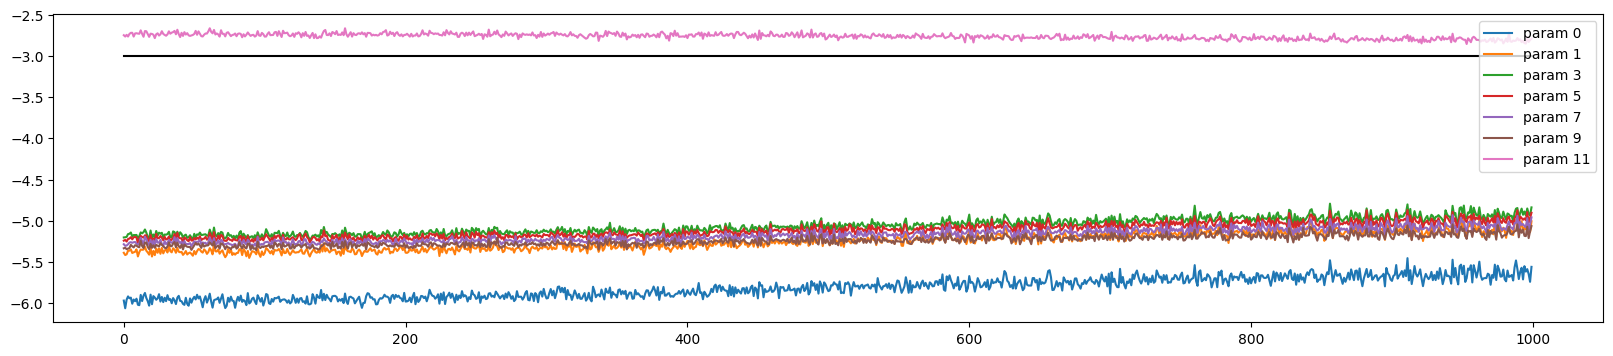

In [47]:
plot_update_weights_ratio(parameters)

## Un détail qui change tout

In [48]:
# Original training
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [49]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)  # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [50]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


In [51]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 4.3092


layer 1 (      Tanh): mean -0.01, std 0.99, saturated: 96.97%
layer 3 (      Tanh): mean -0.05, std 0.98, saturated: 91.59%
layer 5 (      Tanh): mean +0.04, std 0.97, saturated: 90.06%
layer 7 (      Tanh): mean -0.03, std 0.98, saturated: 90.44%
layer 9 (      Tanh): mean -0.03, std 0.98, saturated: 89.53%
layer 1 (      Tanh): mean -0.002507, std 1.533246e-01
layer 3 (      Tanh): mean +0.000241, std 5.989984e-02
layer 5 (      Tanh): mean -0.000538, std 1.758550e-02
layer 7 (      Tanh): mean +0.000122, std 6.267677e-03
layer 9 (      Tanh): mean -0.000094, std 2.010653e-03
weight   (41, 10) | mean +0.007613 | std 5.816863e-01 | grad:data ratio 2.619179e-01
weight  (30, 100) | mean -0.007177 | std 3.267311e-01 | grad:data ratio 1.692126e-01
weight (100, 100) | mean -0.000088 | std 5.626256e-02 | grad:data ratio 3.334684e-02
weight (100, 100) | mean +0.000219 | std 2.106977e-02 | grad:data ratio 1.264180e-02
weight (100, 100) | mean -0.000049 | std 5.897147e-03 | grad:data ratio 3.5

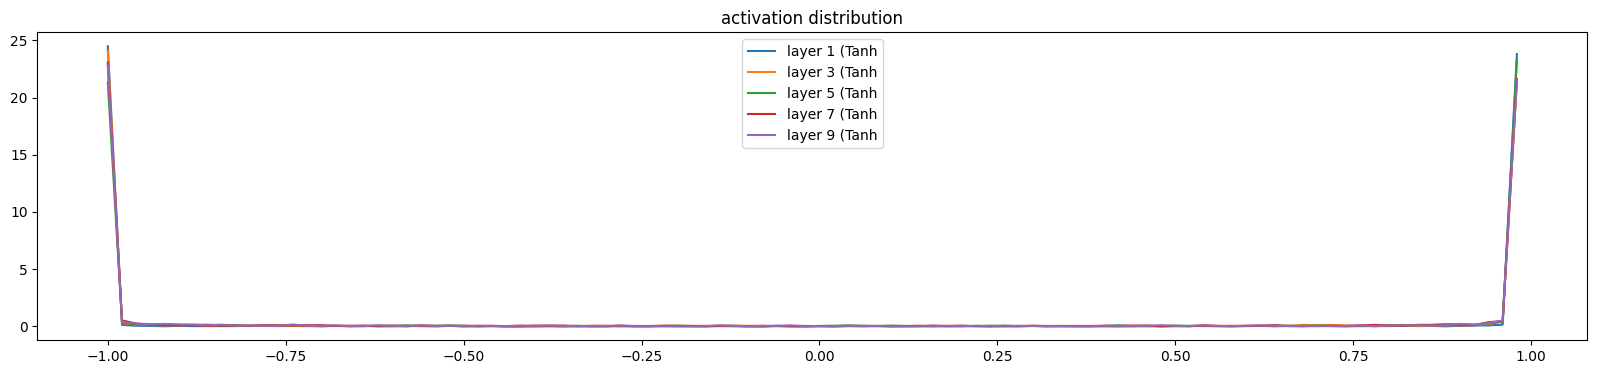

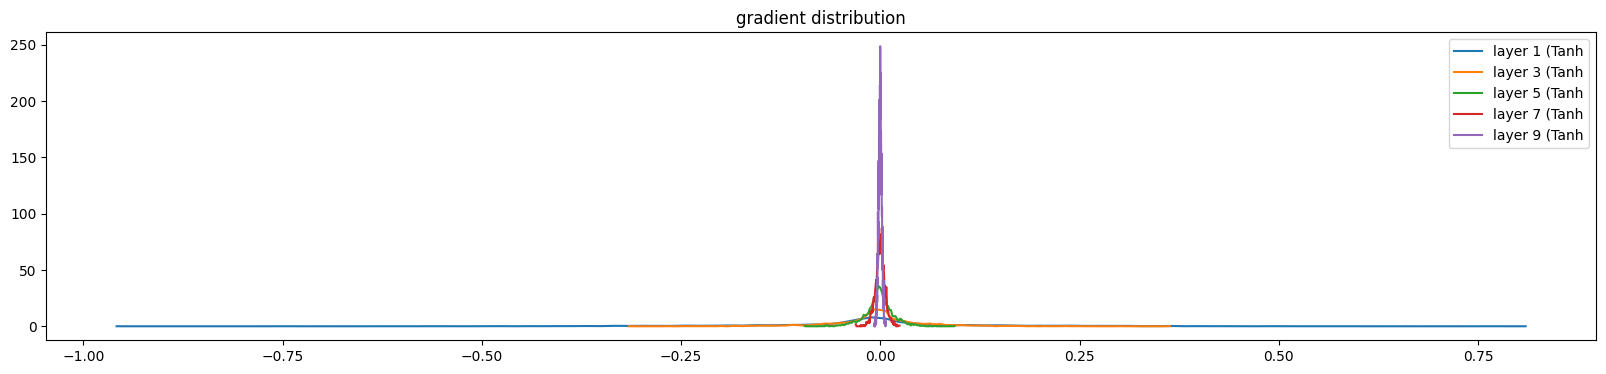

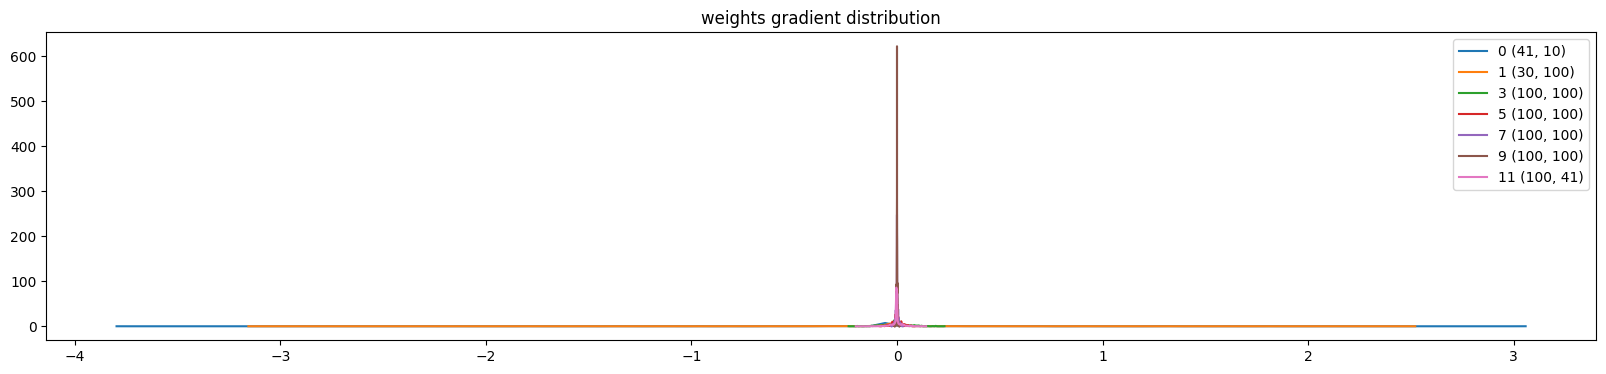

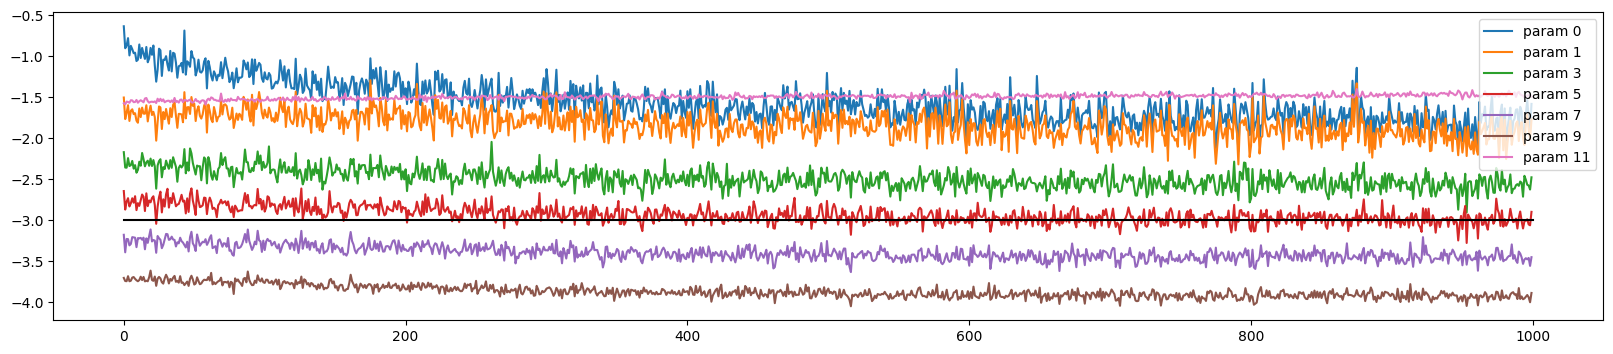

In [52]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)
plot_weight_parameters_gradients(parameters)
plot_update_weights_ratio(parameters)

In [53]:
## Batch Normalization

In [54]:
### Nouvelles couches

In [53]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        #self.weight = torch.randn((fan_in, fan_out), generator=g)
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [54]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
#layers = [
#  Linear(n_embd * context_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, vocab_size), BatchNorm1d(vocab_size),
#]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #layer.weight *= 5/3
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48592


In [55]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        #lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        lr = 1.0
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [56]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.7479


layer 2 (      Tanh): mean -0.02, std 0.65, saturated: 4.59%
layer 5 (      Tanh): mean +0.00, std 0.65, saturated: 5.91%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 4.69%
layer 11 (      Tanh): mean +0.01, std 0.64, saturated: 4.72%
layer 14 (      Tanh): mean +0.05, std 0.64, saturated: 4.53%
layer 2 (      Tanh): mean +0.000000, std 5.403407e-03
layer 5 (      Tanh): mean +0.000000, std 4.949496e-03
layer 8 (      Tanh): mean +0.000000, std 4.487487e-03
layer 11 (      Tanh): mean -0.000000, std 4.113669e-03
layer 14 (      Tanh): mean +0.000000, std 3.792682e-03
weight   (41, 10) | mean +0.000000 | std 1.160022e-02 | grad:data ratio 1.135907e-02
weight  (30, 100) | mean -0.000044 | std 4.012799e-03 | grad:data ratio 3.964094e-03
weight (100, 100) | mean -0.000020 | std 2.044449e-03 | grad:data ratio 2.028677e-03
weight (100, 100) | mean +0.000023 | std 1.817372e-03 | grad:data ratio 1.816360e-03
weight (100, 100) | mean +0.000008 | std 1.625538e-03 | grad:data ratio 1.62

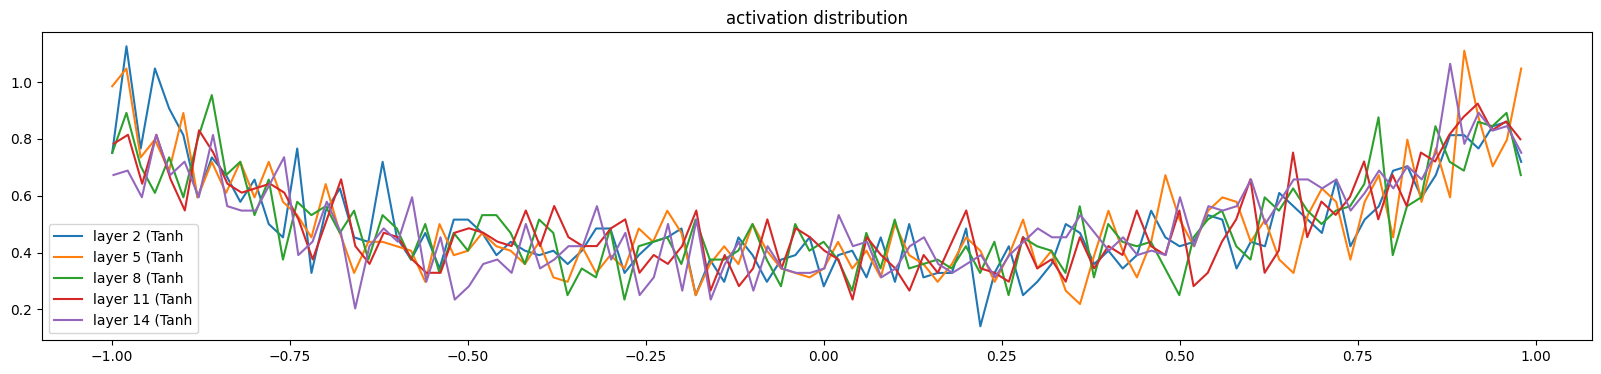

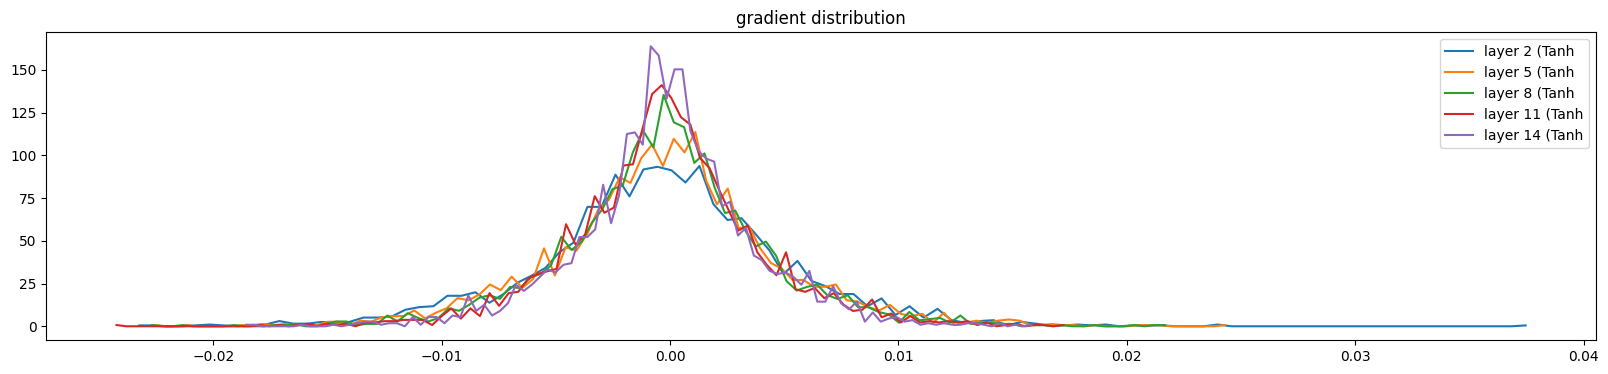

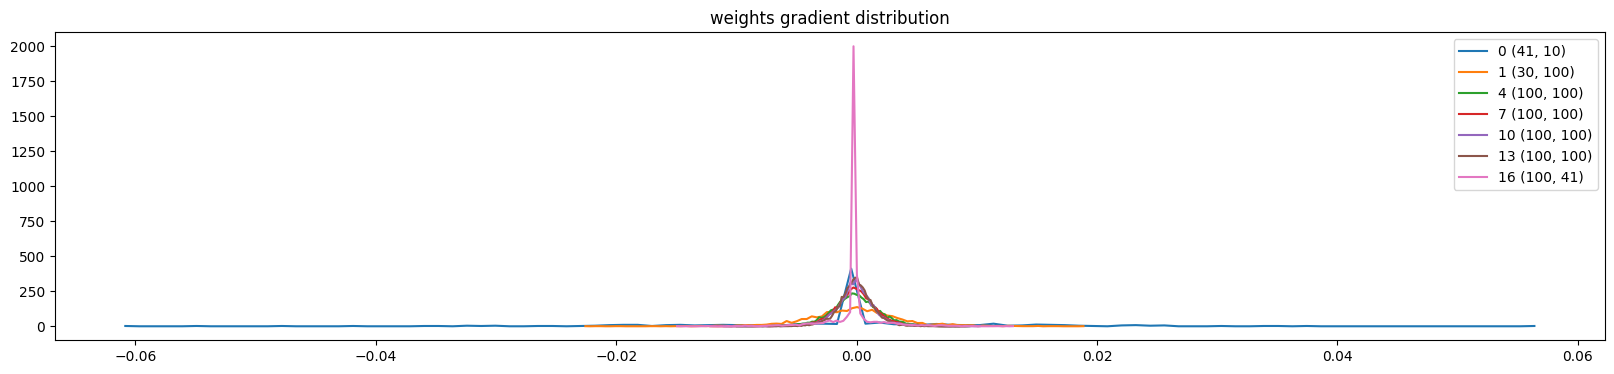

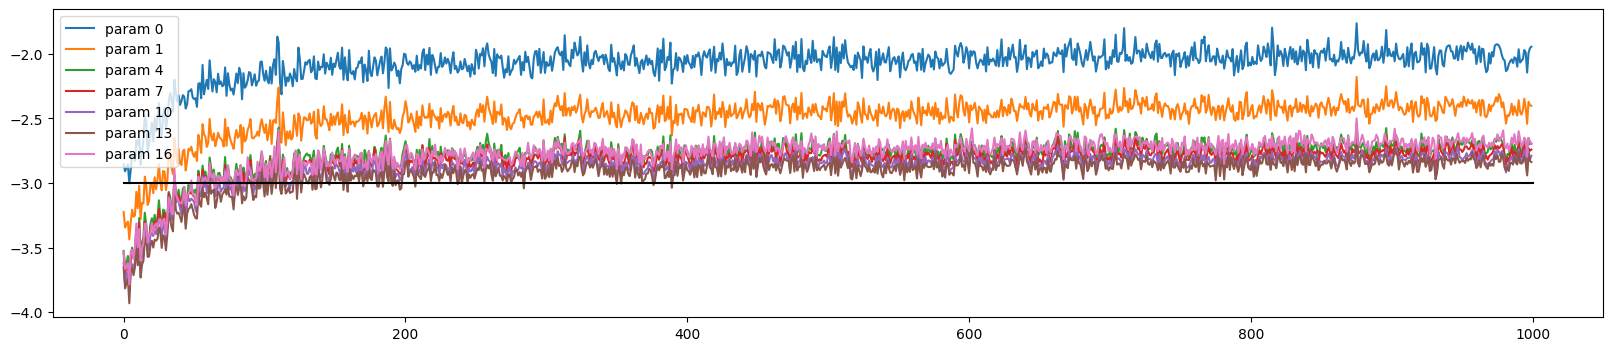

In [57]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)
plot_weight_parameters_gradients(parameters)
plot_update_weights_ratio(parameters)

In [60]:
## Synthèse

In [58]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48592


In [59]:
max_steps = 200000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/ 200000: 3.7479
  10000/ 200000: 1.9356
  20000/ 200000: 1.8173
  30000/ 200000: 1.5111
  40000/ 200000: 1.6997
  50000/ 200000: 1.6669
  60000/ 200000: 1.8971
  70000/ 200000: 1.8667
  80000/ 200000: 1.6408
  90000/ 200000: 1.6528
 100000/ 200000: 2.2495
 110000/ 200000: 2.0517
 120000/ 200000: 2.0586
 130000/ 200000: 1.7323
 140000/ 200000: 1.7154
 150000/ 200000: 1.5548
 160000/ 200000: 1.7653
 170000/ 200000: 1.6377
 180000/ 200000: 1.4785
 190000/ 200000: 1.6350


In [60]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for layer in layers:
  layer.training = False
for _ in range(20):
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        if ix == 0:
            break
        else:
            out.append(ix)

    print(''.join(words.itoc[i] for i in out)) # decode and print the generated word

avenu
exesane
pièces
suppres
apprêtatuels
cumulte
expulsé
posent
posseté
tuteurressorts
modifier
justituabeux
expliquelle
fautre
fauts
jourletti
typothèpe
formants
peunifiennement
dispatributiliées
